# Logistic Regression Classifyer
___

This model is based on:

```Bibtex
@inproceedings{levyContextDependentClaim2014a,
  title = {Context Dependent Claim Detection},
  author = {Levy, Ran and Bilu, Yonatan and Hershcovich, Daniel and Aharoni, Ehud and Slonim, Noam},
  date = {2014},
  url = {https://aclanthology.org/C14-1141/},
}
```

Features:
- sentence-topic similarity
- Linguistic expansion
- Keyword that
- sentiment
- subjectivity

Parameter:

In [17]:
import os

import wandb
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_score, recall_score)
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

from config import DATASETS, PROJECT_NAME
from src.dataset import load_dataset
from src.features import (SentenceTopicSimilarity, Sentiment, Subjectivity,
                          ThatToken)
from src.evaluation import confusion_matrix_plot


In [2]:
MODEL_NAME = "LogisticRegression"
TRACKING = True
FALSE_CLASS_BALANCE = 1.0

dataset = DATASETS["dataset_2014"]

### 0. Load data

In [3]:
X_train, X_test, y_train, y_test = load_dataset(dataset_path=os.path.join(dataset["base_path"], dataset["data"]), false_class_balance=FALSE_CLASS_BALANCE)

### 1. Encode features

In [4]:
text_features = FeatureUnion(transformer_list=[("tf-idf", TfidfVectorizer())])

In [5]:
column_trans = ColumnTransformer(
    [
        ("tf-idf", text_features, "Sentence"),
        ("that", ThatToken(), "Sentence"),
        ("sentiment", Sentiment(), "Sentence"),
        ("subjectivity", Subjectivity(), "Sentence"),
        ("similarity", SentenceTopicSimilarity(), ["Sentence", "Article"]),
    ],
    remainder="drop",
    verbose=True,
)

### 2. Create model

In [6]:
pipe = Pipeline(
    [
        ("preprocessing", column_trans),
        ("scaler", StandardScaler(with_mean=False)),
        ("classify", LogisticRegression(max_iter=200)),
    ],
    verbose=True,
)

### 4. Train model

In [7]:
if TRACKING:
    wandb.init(project=PROJECT_NAME,
            config={
                "model": MODEL_NAME,
                "setup": str(pipe.get_feature_names_out),
                "dataset": dataset["name"],
                "train_data_size": len(X_train),
                "validation_data_size": 0,
                "test_data_size": len(X_test),
                "batch_size": None,
                "learning_rate": None,
                "epochs": None,
                "false_class_balance": FALSE_CLASS_BALANCE
            })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jueri (use `wandb login --relogin` to force relogin)
/home/jueri/.local/share/virtualenvs/claim_model_comparison-fePjuQRa/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [8]:
pipe.fit(X_train, y_train)

[ColumnTransformer] ........ (1 of 5) Processing tf-idf, total=   0.1s
[ColumnTransformer] .......... (2 of 5) Processing that, total=   0.0s
[ColumnTransformer] ..... (3 of 5) Processing sentiment, total=   0.4s
[ColumnTransformer] .. (4 of 5) Processing subjectivity, total=   0.4s
[ColumnTransformer] .... (5 of 5) Processing similarity, total=   2.1s
[Pipeline] ..... (step 1 of 3) Processing preprocessing, total=   2.9s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] .......... (step 3 of 3) Processing classify, total=   0.0s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('tf-idf',
                                                  FeatureUnion(transformer_list=[('tf-idf',
                                                                                  TfidfVectorizer())]),
                                                  'Sentence'),
                                                 ('that', ThatToken(),
                                                  'Sentence'),
                                                 ('sentiment', Sentiment(),
                                                  'Sentence'),
                                                 ('subjectivity',
                                                  Subjectivity(), 'Sentence'),
                                                 ('similarity',
                                                  SentenceTopicSimilarity(),
                                                  ['Sentence', 'Article'])],
           

### 5. Predict results

In [13]:
y_pred = pipe.predict(X_test)

### 6. Evaluate results

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.74      0.71      0.72       235
        True       0.74      0.78      0.76       259

    accuracy                           0.74       494
   macro avg       0.74      0.74      0.74       494
weighted avg       0.74      0.74      0.74       494



In [15]:
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [16]:
if TRACKING:
    wandb.log({'test_f1': f1})
    wandb.log({'test_recall': recall})
    wandb.log({'test_precision': precision})
    wandb.log({'test_accuracy': accuracy})
    wandb.finish()

Error: You must call wandb.init() before wandb.log()

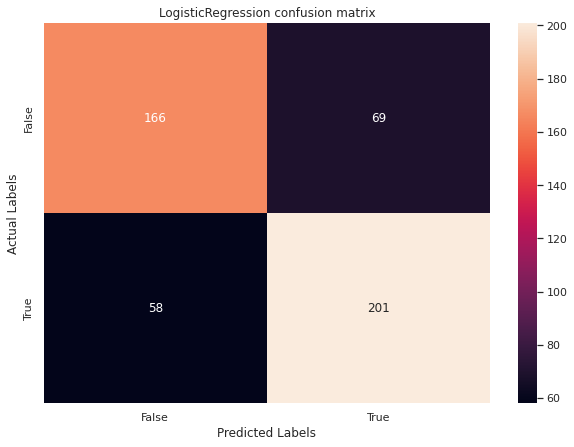

In [18]:
confusion_matrix_plot(y_test, y_pred, label=[False, True], title=MODEL_NAME+" confusion matrix")